In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat
def count_turns(labyrinth):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Rechts, Unten, Links, Oben
    num_turns = 0

    for i in range(1, labyrinth.shape[0] - 1):
        for j in range(1, labyrinth.shape[1] - 1):
            if labyrinth[i, j] == 1:
                valid_neighbors = 0
                for dx, dy in directions:
                    ni, nj = i + dx, j + dy
                    if labyrinth[ni, nj] == 1:
                        valid_neighbors += 1
                if valid_neighbors == 2:  # Zwei gültige Nachbarn bedeuten eine Richtungsänderung
                    num_turns += 1

    return num_turns

In [2]:


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-28' # 2
config_name = 'config_001_hollowelbo.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_259999_hollowelbo.pt'


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_lastunet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_399999_lastunet.pt'


path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-25' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_599999_unet14Mlogits.pt'


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-30' # 2
config_name = 'config_001_auxhollow.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_159999.pt' 

path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_lastunet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_399999_lastunet.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-30' # 2
config_name = 'config_001_auxhollow.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_159999.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZEprotein/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-28' # 2
config_name = 'config_001_auxProtein.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_auxProtein.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-02-10' # 2
config_name = 'config_001_crmnll_001.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_crmnll_001.pt' 

path = 'SavedModels/MAZEelbo/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-02-09' # 2
config_name = 'config_001_elbocrm.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_229999_elbocrm.pt' 

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)


In [3]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'LBJF' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 500
cfg.sampler.is_ordinal = False
#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
model = model.float()
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()


self.input_embedding torch.float32
number of parameters:  7808643
ema state dict function


In [4]:
n_samples = 1000
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples
#np.save('mazes2000_hollow_aux_lbjf4.npy', saved_samples)
correct_mazes = maze_acc(saved_samples)

0it [00:00, ?it/s]/home/pheller/my_python_env/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
500it [11:16,  1.35s/it]


Accuracy: From 1000 are 77.8% solvable.
Average path length: 34.88946015424165 and prob 15.50642673521851%
Average wall length: 126.10925449871465 and prob 56.04855755498429%
Average way length: 64.0012853470437 and prob 28.4450157097972%


In [5]:
correct_mazes = maze_acc(saved_samples)

Accuracy: From 1000 are 77.8% solvable.
Average path length: 34.88946015424165 and prob 15.50642673521851%
Average wall length: 126.10925449871465 and prob 56.04855755498429%
Average way length: 64.0012853470437 and prob 28.4450157097972%


In [ ]:
import numpy as np
n_samples = 2000
steps = [1000]
sampler_name = ['TauL', 'LBJF', 'ExactSampling']#, 'CRMTauL']
cfg.sampler.num_steps = steps[0]
for sampler_n_i in sampler_name:
    data_list = []
    cfg.sampler.name = sampler_n_i
    for i in range(1):
        sampler = sampling_utils.get_sampler(cfg)
        print(f'hollow_crmnll_{sampler_n_i}{1000}_mnist{i}.npy')
        samples, _ = sampler.sample(model, n_samples)
        data_list.append(samples)
    data = np.vstack(data_list)
    print(data.shape)
    np.save(f'maze_hollow_crmnll_{sampler_n_i}{1000}.npy', data)
    correct_mazes = maze_acc(data)


In [ ]:
#np.save('mazes3000_auxprotein2_lbjf.npy', saved_samples)
plot_number = 24

samples = samples.reshape(-1, 1, 15, 15)

fig = plt.figure(figsize=(6, 4)) 
for i in range(plot_number):
    plt.subplot(int(4), int(6), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")

# saving_train_path
#plt.savefig('mazed_data.pdf', bbox_inches="tight", transparent=True, pad_inches=0.03)
plt.show()
plt.close()

In [ ]:
steps = [5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 1000]
from scipy.stats import wasserstein_distance
"""
list_acc = []
n_samples = 3000 #cfg.data.batch_size 
emd_list = []
for step in steps:
    cfg.sampler.num_steps = step
    sampler = sampling_utils.get_sampler(cfg)
    samples, changes = sampler.sample(model, n_samples)
    saved_samples = samples
    np.save(f'Samples/Maze/mazes_hollow_ruleCRMTauL{step}', samples)
    print("Step", cfg.sampler.num_steps)
    correct_mazes = maze_acc(saved_samples)
    emd_dist = []
    for i in range(samples.shape[0]):
        m_g = samples[i, :]
        emd = wasserstein_distance(samples[i, :], true_dl[i, :].cpu().numpy())
        emd_dist.append(emd)
        mean = np.mean(emd_dist)
    print("AVG", mean)
    emd_list.append(mean)
print("EMD", emd_list)
"""
emd_list = []
steps = [5, 10, 15, 20, 30, 50, 100, 250, 500, 1000]
for step in steps:
    samples = np.load(f'Samples/Maze/mazes_hollow_nonordinalCRMTauL{step}.npy')
    #correct_mazes = maze_acc(samples)
    emd_dist = []
    for i in range(samples.shape[0]):
        m_g = samples[i, :]
        emd = wasserstein_distance(samples[i, :], true_dl[i, :].cpu().numpy())
        emd_dist.append(emd)
        mean = np.mean(emd_dist)
    print("AVG", mean)
    emd_list.append(mean)
print("EMD", emd_list)
# 5, 7, 10, 15, 20, 30, 50, #100, 250, 500, 1000 
acc_rule = [1, 11, 32, 56, 63, 71, 79, 82, 83, 83, 85.9]
acc_rule2 = [1, 10, 31, 53, 60, 73, 78, 81, 83, 83, 84]
# 20 30 50, 100, 250, 500

# non ordinaEMD [0.14996533333333337, 0.1200622222222226, 0.09700622222222226, 0.08128711111111113, 0.0768017777777778, 0.07334577777777779, 0.07063466666666665, 0.0672871111111111, 0.06688399999999998, 0.06559644444444442, 0.065]
# emd rule: EMD [0.07427259259259258, 0.0738637037037037, 0.07077185185185185, 0.06911555555555554, 0.06822518518518516, , 0.0676666666666666, 0.06724740740740738, 0.06673777777777776, 0.06650074074074072, 0.659, 0.065]

In [ ]:
#np.save('mazes_auxprotein2.npy', saved_samples)
#saved_samples = np.load(f'Samples/Maze/mazes_hollow_CRMLBJF1000.npy')
#saved_samples = np.load('mazes3000_auxprotein1_lbjf.npy')
correct_mazes = maze_acc(saved_samples)

# acc_taul_nonord = np.array([0, 0, 1, 8, 32, 62, 78, 83, 85])
# acc_rule = [0.1, 0.2, 12, 40, 68, 80, ]

In [ ]:
cfg.data.name = 'Maze3SComplete'
cfg.data.batch_size = 2000

if cfg.data.name == 'Maze3SComplete':
    limit = cfg.data.batch_size
    cfg.data.limit = limit 

dataset = dataset_utils.get_dataset(cfg, device)
dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)

for i in dataloader:
    true_dl = i
    c_i = maze_acc(i.cpu().numpy())
    true_dl = true_dl.reshape(cfg.data.batch_size, -1) #.flatten()

In [ ]:
from scipy.stats import wasserstein_distance
#samples = np.load('mazes2000_hollow_aux_lbjf.npy')
#samples = np.load('Samples/Maze/mazes_hollow_CRMTauL1000.npy')
saved_samples = samples
samples = samples.reshape(-1,225) #.flatten()
samples = samples[:2000]


emd_dist = []
correct_mazes = maze_acc(saved_samples)
for i in range(samples.shape[0]):
    m_g = samples[i, :]
    emd = wasserstein_distance(samples[i, :], true_dl[i, :].cpu().numpy())
    emd_dist.append(emd)
    #print(i, emd_dist)
#print("EMD", wasserstein_distance(samples, true_dl.cpu().numpy()))
#print("EMD", emd_dist)
print("AVG", np.mean(emd_dist))


# NLL Protein: 
# 94% 0.654

# ELBO NLL
# 42% und 0.075

# Hollow Aux:
# 84% 6.79

In [ ]:
from scipy.stats import wasserstein_distance
def hellinger_distance(p,q):
    distance = (1.0 / np.sqrt(2) * np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)))
    return distance
#samples = np.load('mazes_hollow_exact.npy')
bins = np.arange(0, 3)
emd_result = []
steps = [750]
for step in steps:
    samples = np.load('maze_hollow_crmnll_LBJF1000.npy') # f'mazes_hollow_nonordinalCRMTauL{step}.npy')
    emd_list = []
    samples = samples[:2000]
    hell_list = []
    print("step", step)
    samples = samples.reshape(samples.shape[0], -1)
    acc = maze_acc(samples)

    for i in range(samples.shape[0]):
        m_g = samples[i, :]
        m_t = true_dl[i, :].cpu().numpy()
        m_g_prob = np.bincount(m_g) / 3
        m_t_prob = np.bincount(m_t) / 3
        emd_list.append(wasserstein_distance(bins, bins, m_g_prob, m_t_prob))
        hell_list.append(hellinger_distance(m_g_prob, m_t_prob))
    emd_result.append(np.mean(emd_list))
    #print("Step:", step)
    print("# AVG EMD", np.mean(emd_list))
    print("# Hell Distance", np.mean(hell_list))

    m_g_whole = np.bincount(samples.flatten()) / 3
    m_t_whole = np.bincount(true_dl.cpu().numpy().flatten()) / 3
    print("# whole EMD", wasserstein_distance(bins, bins, m_g_whole, m_t_whole))
    print("# whole Hellunger", hellinger_distance(m_g_whole,  m_t_whole))


In [ ]:
# Zählen der Nullen und Zweien in der oberen und unteren Zeile
for i in range(15):
    if grid[0][i] == 0:
        count_zeros += 1
    elif grid[0][i] == 2:
        count_twos += 1
    if grid[14][i] == 0:
        count_zeros += 1
    elif grid[14][i] == 2:
        count_twos += 1
 
# Zählen der Nullen und Zweien in der linken und rechten Spalte
# Ignorieren der Ecken, da sie bereits gezählt wurden
for i in range(1, 14):
    if grid[i][0] == 0:
        count_zeros += 1
    elif grid[i][0] == 2:
        count_twos += 1
    if grid[i][14] == 0:
        count_zeros += 1
    elif grid[i][14] == 2:
        count_twos += 1
 
print("Anzahl der Nullen am Rand:", count_zeros)
print("Anzahl der Zweien am Rand:", count_twos)

In [2]:
import numpy as np
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 1000] )
acc_lbjf = np.array([9, 36, 55, 70, 75, 78, 82, 83, 84, 85, 85] ) / 100
acc_anal = np.array([16, 38, 57, 71, 76, 80, 82, 83, 84, 85, 84]) / 100
acc_taul = np.array([0, 3, 30, 50, 73, 80, 82, 84, 85]) / 100
acc_rule2 = np.array([1, 10, 31, 53, 60, 73, 78, 81, 83, 83, 84]) / 100
# acc_taul_nonord = np.array([0, 0, 0.008, 0.01, 0.1, 0.36, 0.65, 78, 83, 85])
acc_taul_nonord = np.array([0, 0, 0, 0, 0.1, 9, 35, 65, 80, 82, 83]) / 100
mjumps_rate = np.array([0.372, 0.1662, 0.0732, 0.0434, 0.0243, 0.0115, 0.003, 0.00084])
#20: 0.07 30: 50: 0.0434, 0.024, 0.0

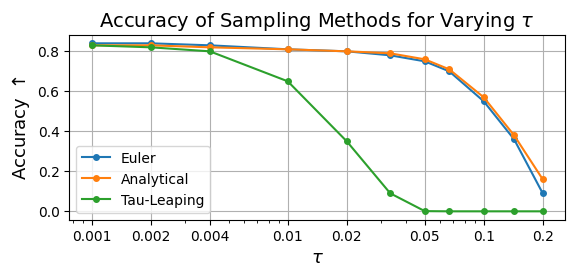

In [3]:
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 1000] )
acc_lbjf = np.array([9, 36, 55, 70, 75, 78, 80, 81, 83, 84, 84] ) / 100
acc_anal = np.array([16, 38, 57, 71, 76, 79, 80, 81, 82, 83, 83]) / 100
#acc_taul = np.array([0, 3, 30, 50, 73, 80, 82, 84, 85]) / 100
acc_rule2 = np.array([1, 10, 31, 53, 60, 73, 78, 81, 82, 83, 83]) / 100
acc_taul_nonord = np.array([0, 0, 0, 0, 0.1, 9, 35, 65, 80, 82, 83]) / 100

steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000] ), 3)

fig = plt.figure(figsize=(width, height))
plt.plot(steps, acc_lbjf, label='Euler', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, acc_anal, label='Analytical', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, acc_taul_nonord, label='Tau-Leaping', marker='o', markersize=marker_size, linewidth=line_width)
#plt.gca().invert_xaxis()
plt.xlabel('$\\tau$', fontsize=13)
#plt.xlabel('NFE', fontsize=13)
plt.ylabel('Accuracy $\\uparrow$', fontsize=13)
plt.title('Accuracy of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
#plt.yscale('log')
plt.xscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('accuracy_plot_tau_semilogx.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()

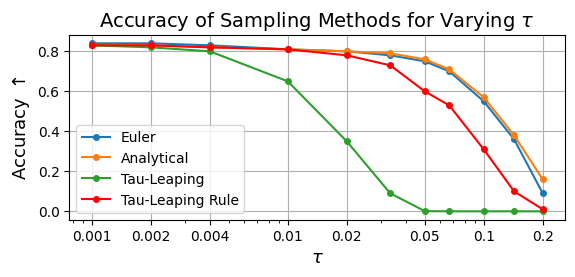

In [4]:
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000] ), 3)
fig = plt.figure(figsize=(width, height))
plt.plot(steps, acc_lbjf, label='Euler', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, acc_anal, label='Analytical', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, acc_taul_nonord, label='Tau-Leaping', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, acc_rule2, label='Tau-Leaping Rule', marker='o', color='red', markersize=marker_size, linewidth=line_width)
#plt.gca().invert_xaxis()
plt.xlabel('$\\tau$', fontsize=13)
#plt.xlabel('NFE', fontsize=13)
plt.ylabel('Accuracy $\\uparrow$', fontsize=13)
plt.title('Accuracy of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
#plt.yscale('log')
plt.xscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('accuracy_plot_tau_semilogx_rule.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()


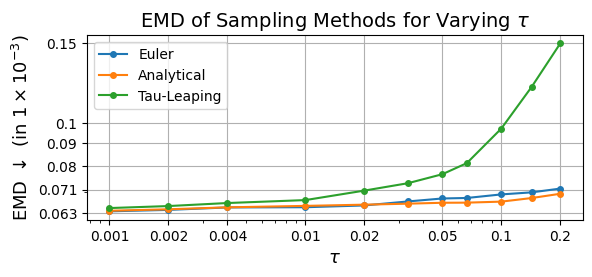

In [6]:
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

steps_plot = np.round(1 / np.array([5, 10,  20, 50, 100, 250, 500, 1000]), 3)
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 1000])
# taul ordinal [0.11571022222222223, 0.07852266666666667, 0.06904, 0.0641937777777778, 0.06518755555555557, 0.06270933333333335, 0.06255288888888891, 0.06282488888888889, 0.06536, 0.0651004444
# [0.07136533333333336, 0.06927288888888891, 0.06681955555555558, 0.06701688888888892, 0.06446933333333334, 0.06353244444444445, 0.06487644444444444, 0.06480533333333333, 0.06684444444444444, 0.06546666666666667
emd_anal = np.array([0.06950222222222226, 0.068,0.0667608888888889, 0.06641244444444447, 0.06637511111111113, 0.066064, 0.06573333333333332, 0.06532133333333335, 0.06483911111111112, 0.0642,  0.06371733333333333])
emd_lbjf = np.array([0.07136533333333336, 0.07,0.06927288888888891, 0.06801688888888892, 0.06784444444444444, 0.06681955555555558, 0.06546666666666667,0.06487644444444444, 0.06480533333333333, 0.0640, 0.06353244444444445])
#emd_taul = np.array([0.11720355555555556, 0.07994488888888888, 0.06799377777777779, 0.06616800000000002, 0.06516800000000002, 0.06496000000000002, 0.064504888888888893, 0.064016, 0.06332266666666667, 0.063296])

emd_taul_no = np.array([0.1499057777777778, 0.12, 0.09572977777777783, 0.0811555555555556, 0.07247822222222228, 0.06952888888888893, 0.06894755555555562, 0.06640533333333336, 0.06489244444444446, 0.0641368888888889, 0.06372977777777777])
# correct: emd_taul_no
emd_taul_no_correct = [0.14996533333333337, 0.1200622222222226, 0.09700622222222226, 0.08128711111111113, 0.0768017777777778, 0.07334577777777779, 0.07063466666666665, 0.0672871111111111, 0.06628399999999998, 0.0652644444444442, 0.0646]
emd_taul_rule =       [0.07627259259259258, 0.0738637037037037, 0.07077185185185185, 0.06911555555555554, 0.06822518518518516, 0.0676666666666666, 0.066924740740740738, 0.06603777777777776, 0.06570074074074072, 0.0652, 0.06458]
#plt.gca().invert_xaxis()
fig = plt.figure(figsize=(width, height))
plt.plot(steps, emd_lbjf, label='Euler', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, emd_anal, label='Analytical', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, emd_taul_no_correct, label='Tau-Leaping', marker='o', markersize=marker_size, linewidth=line_width)
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('EMD $\\downarrow$ (in $1\\times 10^{-3}$)', fontsize=13) 
plt.title('EMD of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend()
plt.yscale('log')
plt.xscale('log')
steps_y = [0.15, 0.1, 0.09, 0.08, 0.071, 0.063]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('emd_plot_tau.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()

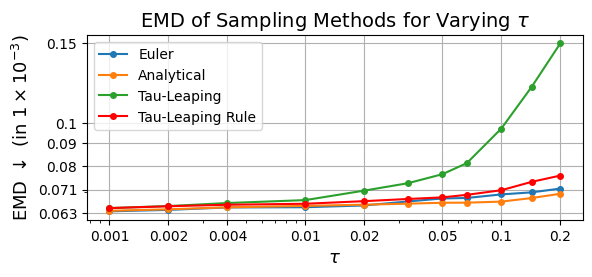

In [7]:
import numpy as np
import matplotlib.pyplot as plt

marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4
fig = plt.figure(figsize=(width, height))
plt.plot(steps, emd_lbjf, label='Euler', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, emd_anal, label='Analytical', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, emd_taul_no_correct, label='Tau-Leaping', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, emd_taul_rule, label='Tau-Leaping Rule', marker='o', color='red', markersize=marker_size, linewidth=line_width)
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('EMD $\\downarrow$ (in $1\\times 10^{-3}$)', fontsize=13) 
plt.title('EMD of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend()
plt.yscale('log')
plt.xscale('log')
steps_y = [0.15, 0.1, 0.09, 0.08, 0.071, 0.063]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('emd_plot_tau_rule.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

steps = 1 / np.array([5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30, 50, 100, 250, 500, 1000] )
mjumps_rate = [0.6085251628305858, 0.5494559409182388, 0.5024725555269348, 0.46047110249335016, 0.42721587669909056, 0.3971528976831892, 0.3485456803645144, 0.29737690992794547, 0.2594061472780591, 0.23819152995776705, 0.1982492844580715, 0.17059221048452358, 0.11267130391333513, 0.06186160933420365, 0.025205536736870884, 0.0069328674408784, 0.0]
steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000] ), 3)
#plt.gca().invert_xaxis()
fig = plt.figure(figsize=(width, height))
plt.plot(steps, mjumps_rate, marker='o', color='black', markersize=marker_size, linewidth=line_width)
plt.ylabel('Avg. Rejection Rate', fontsize=13)
plt.xlabel('$\\tau$', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme for Varying $\\tau$', fontsize=14)
plt.grid(True)
plt.xscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('rej_rate_plot.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4


steps_plot = np.round(1 / np.array([5, 10, 20, 50,100, 250, 500] ), 3)
steps = np.round( 1/ np.array([5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30, 50, 100, 250, 500]), 3)
#[0.35877892914199944, 0.30981472686842804, 0.28292983201023614, 0.26155478599379806, 0.23674716318645556, 0.19564409941178987, 0.16951416165006652, 0.139516824660454, 0.13376598868398556, 0.09849632794965446]
#rej_rate_synthetic = np.array([0.24, 0.116, 0.075, 0.0554, 0.036, 0.021, 0.0094, 0.0019, 0.00039])
avg_ch_dim = np.array([0.40332350057517347, 0.3547955131536109, 0.31542669212748053, 0.28031873983265554, 0.25682451055878963, 0.22954889368547216, 0.19837796729464874, 0.16369641453630393, 0.13639601140774074, 0.12181723796934807, 0.09852055607115565, 0.08435660730246927, 0.048324176421086974, 0.024412986098583958, 0.007594022551450553, 0.003041762941834382]) 
#plt.gca().invert_xaxis()
fig = plt.figure(figsize=(width, height))
plt.plot(steps, avg_ch_dim , marker='o', color='black', markersize=marker_size, linewidth=line_width)
plt.ylabel('Avg. Rejection Rate', fontsize=13)
plt.xlabel('$\\tau$', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme for Varying $\\tau$', fontsize=14)
plt.grid(True)
plt.xscale('log')
plt.xticks(steps_plot, steps_plot)
plt.savefig('rej_rate_synthetic_tau_plot.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()


In [ ]:
import numpy as np
steps = np.round( 1/ np.array([5, 7, 10,  15,  20,  30, 50, 100, 250, 500]), 3)
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500])
mmd_taul = np.array([19, 6.2, 1.6, 0.587, 0.39, 0.29, 0.23, 0.17, 0.162, 0.137])
rej_rate = np.array([0.40332350057517347, 0.31542669212748053, 0.22954889368547216,0.16369641453630393, 0.12181723796934807, 0.08435660730246927, 0.048324176421086974, 0.024412986098583958, 0.007594022551450553, 0.003041762941834382]) 
correlation = np.corrcoef(mmd_taul, rej_rate )[0, 1]

# Print the correlation coefficient
print("Correlation coefficient:", correlation)


In [ ]:
"""
steps = np.array([5, 10,15, 20, 30, 50, 100, 250, 500]) 
change_taul_ord = np.array([0.3787, 0.2247, 0.1595, 0.1239, 0.0861, 0.0538, 0.02755, 0.0106, 0.0049])
clamp_taul_ord = np.array([0.238, 0.1153, 0.075, 0.0552 ,0.036,0.021, 0.00936,0.00192,0.000384])
change_taul_nonord = np.array([0.142, 0.11, 0.0840, 0.069, 0.05, 0.0324, 0.019, 0.0087,0.0045])
change_lbjf = np.array([0.42, 0.24, 0.168, 0.13, 0.0887, 0.055, 0.028, 0.0115, 0.0054])
change_exact = np.array([0.206, 0.137,0.1006,0.08, 0.0567, 0.0358, 0.0187,0.0077,0.0039])

plt.plot(steps, change_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, change_exact, label='Analytical', marker='o')
plt.plot(steps, change_taul_ord , label='Tau-Leaping', marker='o')
plt.plot(steps, change_taul_nonord , label='Tau-Leaping with Rejection', marker='o')
plt.ylabel('Avg. Proportion of Changing Dim', fontsize=13)
plt.xlabel('NFE', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=14)
plt.grid(True)
plt.legend()
plt.xticks(steps_plot, steps_plot)
plt.show()
"""

In [ ]:
"""

change_taul_nonord_time = [0.0, 0.2691875100135803, 0.21253125369548798, 0.16771875321865082, 0.13959375023841858, 0.11800000816583633, 0.08646875619888306, 0.05946875363588333, 0.036781251430511475, 0.001500000013038516]
change_taul_ord_time = [1.0, 0.3410625159740448, 0.24518750607967377, 0.1925000101327896, 0.15309375524520874, 0.11903125792741776, 0.09334375709295273, 0.06428125500679016, 0.038750000298023224, 0.00043750001350417733]


steps = np.linspace(1, 0, len(change_taul_nonord_time))
plt.gca().invert_xaxis()
plt.plot(steps, change_taul_nonord_time, label='Tau-Leaping Rejection', color='purple')
plt.plot(steps, change_taul_ord_time, label='Tau-Leaping', color='green')
plt.xlabel('Time', fontsize=13)
plt.ylabel('Avg. Proportion of Changing Dimensions', fontsize=13)
plt.legend()
plt.grid(True)
plt.title('Avg. Proportion of Changing Dimension')
#plt.savefig('PNGs/changing_dim_maze50_ordinal.png')
plt.show()
"""

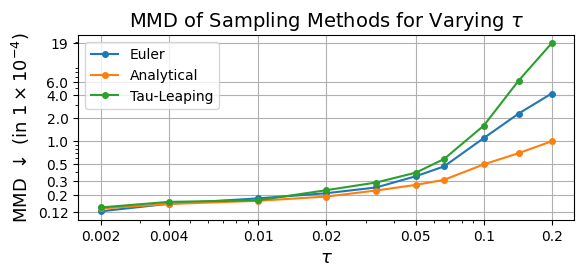

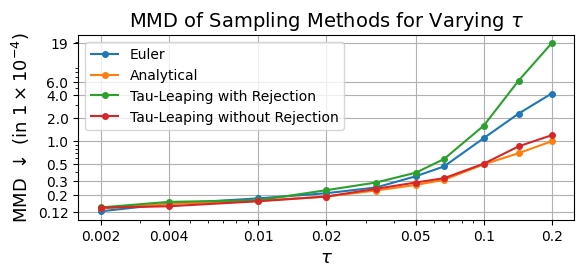

In [9]:
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500])
steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500]), 3)
steps_y = [19, 6.0, 4.0, 2.0, 1.0, 0.5, 0.3, 0.2, 0.12]

mmd_lbjf = np.array([4.2, 2.3, 1.1, 0.47 ,0.35, 0.25, 0.21, 0.18, 0.153, 0.122])
mmd_taul = np.array([19, 6.2, 1.6, 0.587, 0.39, 0.29, 0.23, 0.17, 0.162, 0.137])
mmd_exact = np.array([1.0, 0.7, 0.5, 0.314, 0.27, 0.228, 0.19, 0.1675, 0.152, 0.133])
fig = plt.figure(figsize=(width, height))
plt.plot(steps, mmd_lbjf , label='Euler', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, mmd_exact, label='Analytical', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, mmd_taul, label='Tau-Leaping', marker='o', markersize=marker_size, linewidth=line_width)
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('MMD $\\downarrow$ (in $1\\times 10^{-4}$)', fontsize=13) 
plt.title('MMD of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, steps_y)
plt.savefig('mmd_plot_tau.pdf', format='pdf', bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()


mmd_lbjf = np.array([4.2, 2.3, 1.1, 0.47 ,0.35, 0.25, 0.21, 0.18, 0.153, 0.122])
mmd_taul = np.array([19, 6.2, 1.6, 0.587, 0.39, 0.29, 0.23, 0.17, 0.162, 0.137])
mmd_exact = np.array([1.0, 0.7, 0.5, 0.314, 0.27, 0.228, 0.19, 0.1675, 0.152, 0.133])
mmd_taul_wo = np.array([1.2, 0.86, 0.51, 0.33, 0.29, 0.24, 0.19, 0.165, 0.142, 0.136])




# Create the plot with the specified figure size
fig = plt.figure(figsize=(width, height))
plt.plot(steps, mmd_lbjf , label='Euler', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, mmd_exact, label='Analytical', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, mmd_taul, label='Tau-Leaping with Rejection', marker='o', markersize=marker_size, linewidth=line_width)
plt.plot(steps, mmd_taul_wo, label='Tau-Leaping without Rejection', marker='o', markersize=marker_size, linewidth=line_width)
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('MMD $\\downarrow$ (in $1\\times 10^{-4}$)', fontsize=13) 
plt.title('MMD of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, steps_y)
plt.savefig('mmd_plot_first20_worejection_tau.pdf', bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()

In [ ]:
plot_number = 24
cfg.data.name = 'Maze3SComplete'
cfg.data.batch_size = plot_number 

if cfg.data.name == 'Maze3SComplete':
    limit = cfg.data.batch_size
    cfg.data.limit = limit 

dataset = dataset_utils.get_dataset(cfg, device)
dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)


for true_data in dataloader:
    print(true_data.shape)
true_data = true_data.cpu().numpy()
fig = plt.figure(figsize=(6, 4)) 
for i in range(plot_number):
    plt.subplot(int(4), int(6), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(true_data[i, ...], (1,2,0)), cmap="gray")

# saving_train_path
plt.savefig('mazed_data.pdf', bbox_inches="tight", transparent=True, pad_inches=0.03)
plt.show()
plt.close()
